<img src="https://www.bertelsmann.com/media/startseite-buehne/bertelsmann-buehne-3200-800_stage_gt_1200_grid.jpg" width="100%">

# PART 0: Data cleaning and Data processing

This analysis of the **Bertelsmann-Arvato** data set will be a customer segmentation where a data set compiled with customers from a mail-order company is compared with a data set sampled from the general population of Germany.
Data in this project provided as Bertelsmann Arvato Analytics:
* Demographics data of customers of a mail-order sales company in Germany,
* Was analyzed and compared against demographics information for the general population.
#### Problem Statement
The main question of interest is to identify segments of the population that are most likely to be customers of their products for a mail-out campaign.


The main steps in this notebooks:
1. [Load the datas and Import Libraries](#1) 
2. [Preprocesing the data](#2)
3. [Feature Engineering](#3)
4. [Conclusion](#4).

---
<a id="1"></a>
# 1. Load the datas and Import Libraries


#### Summary about datas
The first step in this process is to read all the data from the different sources and check if this data have correct formats.

The data and sources to read in this project are four:

- **`Udacity_AZDIAS_052018.csv`**: <br>Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- **`Udacity_CUSTOMERS_052018.csv`**: <br>Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- **`Udacity_MAILOUT_052018_TRAIN.csv`**: <br>Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- **`Udacity_MAILOUT_052018_TEST.csv`**:<br> Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


#### Choose Platform

In [5]:
use_colab=0  # When you want to use COLAB, assign 1 to use_colab
if use_colab==1:
    # Use Colab
    # Connecting with Google Drive
    from google.colab import drive
    drive.mount('/content/drive')  
    #drive.flush_and_unmount()   
    
    # Connecting to Path
    import sys
    sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
    
    # Install Some Library
    !pip install catboost
    !pip install category_encoders
    !pip install yellowbrick
    !pip install h2o

    # Files with Path of Data from Colab
    attribute_file = '../content/drive/My Drive/Studying_Data/Last/data/DIAS Attributes - Values 2017.xlsx'
    azdias_file = '../content/drive/My Drive/Studying_Data/Last/data/azdias.csv'
    customers_file = '../content/drive/My Drive/Studying_Data/Last/data/customers.csv'
    train_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_train'
    test_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_test'
else:
    # Use data from My Local
    # Files with PATH
    attribute_file = '../Last/data/DIAS Attributes - Values 2017.xlsx'
    azdias_file = '../Last/data/azdias.csv'
    customers_file = '../Last/data/customers.csv'
    train_file = '../Last/data/mailout_train'
    test_file = '../Last/data/mailout_test'

##### Import Libraries

In [6]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import sys
import os

import seaborn as sns
import matplotlib.pyplot as plt

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# Import my libraries for this project
from myutils2.utils import (attribute,
                           row_missing_value,
                           N_unique,
                           report_missing_values,
                           code_to_nan,
                           encode_map_age,
                           encode_df_PJ,
                           encode_df_EIN,
                           drop)
seed = 29


<a id="3"></a>
## Loading of Datas and Overview to Datas

#### Loading data

Firstly, after checking data, i have seen that _**` ['X','XX'] `**_ causes problem in some features.<br> 
To fix it, defined them as **` NaN `**<br>

- **`azdias`**    : I called **azdias** for demographics data for the **general population of Germany**
- **`customers`** : I called **customers** for demographics data for **customers of a mail-order company**

In [9]:
azdias    = pd.read_csv(azdias_file, 
                        na_values=['X','XX'],
                        index_col=0)
customers = pd.read_csv(customers_file, 
                        na_values=['X','XX'], 
                        index_col=0)
azdias.set_index('LNR',inplace=True)
customers.set_index('LNR',inplace=True)

display(azdias.head(3))
display(customers.head(3))

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,6,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1.0,13.0,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,...,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,0,...,NaN,NaN,NaN,3,3,6,2,3,4,5,6,4,1,2,3,1,7,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,6,...,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


#### Overview to Datas

In [10]:
# Shape of Azdias and Customers Dataframes
print('Rows and Columns of General Population: {}'.format(azdias.shape))
print('Rows and Columns of Customers.........: {}'.format(customers.shape))

Rows and Columns of General Population: (891221, 365)
Rows and Columns of Customers.........: (191652, 368)


In [11]:
# Quick view to Azdias and Customers Dataframes
print('Dataframe of Azdias:')
azdias.info()
print('\n','Dataframe of Customers:')
customers.info()

Dataframe of Azdias:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(269), int64(92), object(4)
memory usage: 2.4+ GB

 Dataframe of Customers:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Columns: 368 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(269), int64(93), object(6)
memory usage: 539.5+ MB


---
<a id="2"></a>
# 2. Preprocesing the data

### Read Attributes Dataset and understand the data types of features of  Azdias and Customer 

In [12]:
# Create attribute dataframe
## filling 'Attribute' feature with ffill()
df_attr = pd.read_excel(attribute_file, 
                        header=1, 
                        usecols=['Attribute', 'Meaning', 'Value'])
df_attr['Attribute'] = df_attr['Attribute'].ffill()

## drop null-useless rows
df_attr.dropna(inplace=True);

### Find and Understanding Missing - Unknowns Values of Features

**Attributes information** files says that in some columns there are **missing-unknown** value.
Checking data and find that for **missing-unknown** value in some features. To fix it, defined them as **` NaN `**

In [13]:
columns= ['Attribute','Meaning','Value']
mask = df_attr['Meaning'].str.contains('unknown')
feat_mask = df_attr[columns][mask].set_index('Attribute')
feat_mask.head(10)

,Meaning,Value
Attribute,,
AGER_TYP,unknown,-1
ALTERSKATEGORIE_GROB,unknown,"-1, 0"
ALTER_HH,unknown / no main age detectable,0
ANREDE_KZ,unknown,"-1, 0"
BALLRAUM,unknown,-1
BIP_FLAG,unknown,-1
CAMEO_DEUG_2015,unknown,-1
CAMEO_DEUINTL_2015,unknown,-1
CJT_GESAMTTYP,unknown,0


When investigate in attributes information file there were found **233 features** about **missing-unknown value**. Let's  convert a list of value into dictionary with default value `np.nan` to **Azdias** and **Customers** data frames

In [14]:
df_attr

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly
...,...,...,...
2253,ZABEOTYP,2,smart
2254,ZABEOTYP,3,fair supplied
2255,ZABEOTYP,4,price driven
2256,ZABEOTYP,5,seeking orientation


In [15]:
# Converting Unknown values to NaN values in Azdias and Customers Dataframes
code_to_nan(azdias, attribute_file)
code_to_nan(customers, attribute_file)

### Sync Columns of Customers and Azdias Dataframes

In [16]:
# Check the excess columns between customers and azdias dataframe
excess_col_customer = list(set(customers.columns.tolist()) - set(azdias.columns.tolist()))
display(excess_col_customer)
display(customers[excess_col_customer].head(3))

['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']

,ONLINE_PURCHASE,CUSTOMER_GROUP,PRODUCT_GROUP
LNR,,,
9626,0,MULTI_BUYER,COSMETIC_AND_FOOD
9628,0,SINGLE_BUYER,FOOD
143872,0,MULTI_BUYER,COSMETIC_AND_FOOD


From above, **3 columns** in **`customers`** does not appear to be demographic data like all the columns in **`azdias`**. Thereof, I can remove these 3 extra columns from our analysis. These columus are:
- 'PRODUCT_GROUP' 
- 'CUSTOMER_GROUP'
- 'ONLINE_PURCHASE'

In [17]:
# Removing of excessing columns from Customers Dataframe
drop(customers,excess_col_customer)

### Missing values in Rows

In [18]:
row_missing_value(azdias, value=100)
row_missing_value(customers, value=100)

Total ROW numbers Originally...........................: 891221
Total ROW numbers After dropping missing rows under 100: 785346
Total ROW numbers Originally...........................: 191652
Total ROW numbers After dropping missing rows under 100: 140358


### Missing values in Columns
I classified it as **`High-Low-Zero`** of data sets features according to **missing values** of data.

In [19]:
# Creating count and percentage of Null values of features in Azdias and Customers Dataframes
azdias_miss_report = report_missing_values(azdias)
customers_miss_report = report_missing_values(customers)

In [20]:
display(azdias_miss_report.head())
display(customers_miss_report.head())

,column type,null values (nb),null values (%),level,N_unique
ALTER_KIND4,float64,784181,99.8517,High,12
TITEL_KZ,float64,783300,99.7395,High,5
ALTER_KIND3,float64,779362,99.238,High,15
ALTER_KIND2,float64,756832,96.3692,High,17
ALTER_KIND1,float64,707201,90.0496,High,17


,column type,null values (nb),null values (%),level,N_unique
ALTER_KIND4,float64,140125,99.834,High,10
ALTER_KIND3,float64,139124,99.1208,High,14
TITEL_KZ,float64,138122,98.4069,High,4
ALTER_KIND2,float64,135436,96.4933,High,17
ALTER_KIND1,float64,129004,91.9107,High,17


#### Plot Distrubution Missing Value of Data

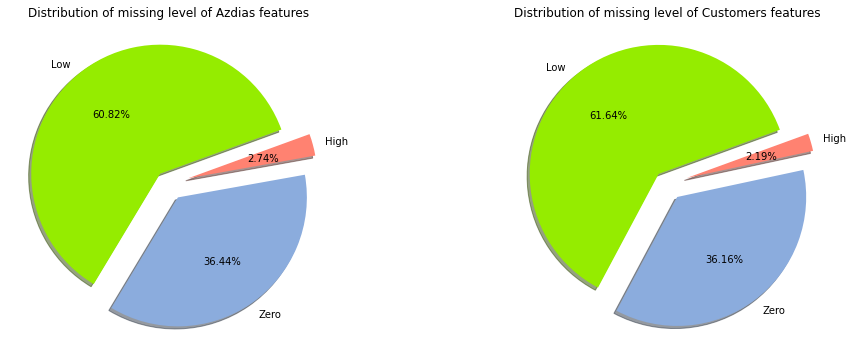

In [21]:
# Distribution of missing level of Azdias and Customers features

fig, axes= plt.subplots(nrows=1, ncols=2,figsize=(15,5))
explode = (0.1,0.13, 0.16)
colors = ['#95EC00', '#8BACDD', '#FF8271']
labels = ['Low','Zero','High']

axes[0].pie(azdias_miss_report['level'].value_counts(), 
            explode=explode, 
            labels=labels,
            colors=colors,
            autopct='%1.2f%%',
            shadow=True,
            startangle=20)
axes[0].set_title('Distribution of missing level of Azdias features')

axes[1].pie(customers_miss_report['level'].value_counts(), 
            explode=explode, 
            labels=labels,
            colors=colors,
            autopct='%1.2f%%',
            shadow=True,
            startangle=20)
axes[1].set_title('Distribution of missing level of Customers features')

plt.tight_layout();

#### Upon null values identifying columns to be removed

In [22]:
azdias_c = azdias_miss_report.groupby('level')[['column type']].count().rename(columns={'column type':'azdias'})
customers_c = customers_miss_report.groupby('level')[['column type']].count().rename(columns={'column type':'customer'})

na_table = azdias_c.join(customers_c)
na_table

,azdias,customer
level,,
High,10,8
Low,133,132
Zero,222,225


In [23]:
miss_report = azdias_miss_report[['null values (%)']].join(customers_miss_report[['null values (%)']],
                                                     how='outer',
                                                     lsuffix='_azdias',
                                                     rsuffix='_customers').sort_values(
                                                     by='null values (%)_azdias', ascending=False)

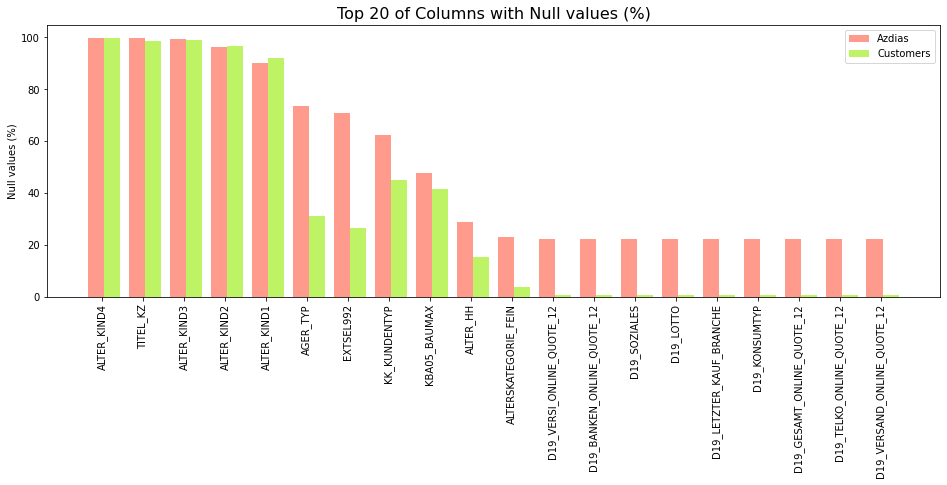

In [24]:
plt.tight_layout                
plt.figure(figsize=(16,5))

miss_report = miss_report.head(20)
x = np.arange(len(miss_report))

plt.bar(x, miss_report['null values (%)_azdias'], label='Azdias', width=0.4, color='#FF5842',  alpha=0.6)
plt.bar(x+0.4, miss_report['null values (%)_customers'], label='Customers', width=0.4, color='#95EC00',  alpha=0.6)

plt.title('Top 20 of Columns with Null values (%)', size=16);
plt.xticks(x+0.15, miss_report.index, rotation=90)
plt.ylabel('Null values (%)')

plt.legend();

#### Null Values

In [25]:
# Choosing of High Level Missing Values of features
high_lev_column_az = azdias_miss_report[azdias_miss_report['level']=='High'].index.values.tolist()
high_lev_column_cus = customers_miss_report[customers_miss_report['level']=='High'].index.values.tolist()

# Finding similar columns of high_lev_col
drop_miss_col = set(high_lev_column_az).intersection(set(high_lev_column_cus))

Columns with  missing values at the **'high'** level were observed to have _**the same columns**_ in datasets of **azdias** and **customers**. The number of column is **8** and name are:
- 'ALTER_KIND4'
- 'KK_KUNDENTYP'
- 'ALTER_KIND3'
- 'ALTER_KIND2'
- 'ALTER_KIND1'
- 'TITEL_KZ'
- 'AGER_TYP'
- 'KBA05_BAUMAX'

In [26]:
# Dropping drop_miss_col from Azdias and Customers Dataframes
drop(azdias,drop_miss_col)
drop(customers,drop_miss_col)

In [27]:
# Shape of Azdias and Customers Dataframes
print('Rows and Columns of General Population: {}'.format(azdias.shape))
print('Rows and Columns of Customers.........: {}'.format(customers.shape))

Rows and Columns of General Population: (785346, 357)
Rows and Columns of Customers.........: (140358, 357)


### Descriptive Analysis

In [28]:
des_analysis_a = azdias.describe().T
des_analysis_c = customers.describe().T

In [29]:
display(des_analysis_a.head())
display(des_analysis_c.head())

,count,mean,std,min,25%,50%,75%,max
AKT_DAT_KL,785346.0,4.404983,3.638560,1.0,1.0,3.0,9.0,9.0
ALTER_HH,560022.0,15.291133,3.804120,1.0,13.0,16.0,18.0,21.0
ALTERSKATEGORIE_FEIN,605766.0,13.690354,5.080017,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,785346.0,8.289065,15.525302,0.0,1.0,4.0,10.0,595.0
ANZ_HH_TITEL,781664.0,0.040052,0.315780,0.0,0.0,0.0,0.0,20.0


,count,mean,std,min,25%,50%,75%,max
AKT_DAT_KL,140358.0,1.730311,1.944810,1.0,1.0,1.0,1.0,9.0
ALTER_HH,119059.0,13.401734,4.369047,2.0,10.0,13.0,17.0,21.0
ALTERSKATEGORIE_FEIN,135438.0,10.317407,4.128577,0.0,9.0,10.0,13.0,25.0
ANZ_HAUSHALTE_AKTIV,140358.0,4.880919,13.762387,0.0,1.0,1.0,4.0,523.0
ANZ_HH_TITEL,138236.0,0.064274,0.503339,0.0,0.0,0.0,0.0,20.0


### Encoding some Columns

**CUSTOMERS** dataset contains is _target dataset_ that as our customer's source data. Therefore, we will **act on the column investigation** on this dataset.
As we begin this work, which is a preliminary preparation for **OneHotEncoding**, which we will use **before implementing the model**, we will start with **`  the columns with high 'nunique' value  `**.

Here is the purpose is to identify **important columns** and significantly **reduce these columns's unique values**.

In [30]:
customers.nunique().sort_values(ascending=False)[:15]

EINGEFUEGT_AM                 2760
KBA13_ANZAHL_PKW              1250
ANZ_STATISTISCHE_HAUSHALTE     208
ANZ_HAUSHALTE_AKTIV            208
GEBURTSJAHR                    113
EXTSEL992                       56
VERDICHTUNGSRAUM                46
CAMEO_DEU_2015                  44
LP_LEBENSPHASE_FEIN             41
D19_LETZTER_KAUF_BRANCHE        35
EINGEZOGENAM_HH_JAHR            33
MIN_GEBAEUDEJAHR                29
ALTERSKATEGORIE_FEIN            25
CAMEO_INTL_2015                 21
ALTER_HH                        20
dtype: int64

---

#### Encode and Investigation of some feutures

##### 01: Encode and Investigation of 'LNR' feuture

**`LNR`**, In this column give us ID information.<br>


* **Result:** <br>
We set column of **`LNR`** to index.

##### 02: Encode and Investigation of 'EINGEFUEGT_AM' feuture

**`EINGEFUEGT_AM`**, In this column give us year-mount-day information. We transform year to index from **`EINGEFUEGT_AM`** feature into **`EINGEFUEGT_ind`**<br>

In [31]:
# 02: Encoding of 'EINGEFUEGT_AM' feuture into EINGEFUEGT_ind
encode_df_EIN(azdias)
encode_df_EIN(customers)

In [32]:
a = azdias['EINGEFUEGT_ind'].value_counts()
c = customers['EINGEFUEGT_ind'].value_counts()
a.name ='Azdias_EINGEFUEGT_ind'
c.name= 'Customers_EINGEFUEGT_ind'

pd.concat([a,c], axis=1, ).sort_index(ascending=False).head()

,Azdias_EINGEFUEGT_ind,Customers_EINGEFUEGT_ind
22,3,NaN
21,573887,108495.0
20,23981,3871.0
19,28647,2810.0
18,42225,5635.0


In [33]:
a_per = sum(sorted(a.values[:5]))/azdias.shape[0]
c_per = sum(sorted(c.values[:5]))/customers.shape[0]
print('Percentage of First 7 unique value for Azdias....:',a_per)
print('Percentage of First 7 unique value for Customers.:',c_per)

Percentage of First 7 unique value for Azdias....: 0.889132942677495
Percentage of First 7 unique value for Customers.: 0.9029766739337979


* **Result:** <br>
Most probably first records  are taken like 22 years ago and that year contains almost %60 of data. Also last 16 to 21 years contains ~%90 of data.<br>
We drop this column due to huge skewness. Drop  **`EINGEFUEGT_AM`** and **`EINGEFUEGT_idn`** columns. <br>

In [34]:
drop_col_list = ['EINGEFUEGT_AM','EINGEFUEGT_ind']

##### 03: Encode and Investigation of some feutures
- KBA13_ANZAHL_PKW'
- 'ANZ_HAUSHALTE_AKTIV'
- 'ANZ_STATISTISCHE_HAUSHALTE'

**`KBA13_ANZAHL_PKW`**: In this column give us number of cars in the PLZ8 . This column type is **NUMERIC**.<br>
**`ANZ_HAUSHALTE_AKTIV`**: In this column give us number of households in the building. This column type is **NUMERIC**.<br>
**`ANZ_STATISTISCHE_HAUSHALTE`**: In this column give us in Germany a census data is given about statistical households, here its number is counted.This column type is **NUMERIC**.<br>
* **Result:** <br>
We use these columns: **`KBA13_ANZAHL_PKW`**, **`ANZ_STATISTISCHE_HAUSHALTE`** and **`ANZ_HAUSHALTE_AKTIV`**


##### 04: Encode and Investigation of 'GEBURTSJAHR' feuture

**`GEBURTSJAHR`**, In this column give us year of birth. This column type is **NUMERIC**.<br>

* **Result:** <br>
We use this column **`GEBURTSJAHR`** after below process:
    - In this column it has `0` (zero). That means **wrong** or **no entry**. We should replace **zero** with **NaN**
    - Divided the values into categorical with {190:193, 191:193, 192:193, 200:199, 201:np.NaN}

In [35]:
# Implamenting map_age function for GEBURTSJAHR feature
encode_map_age(customers)
encode_map_age(azdias)

##### 05: Encode and Investigation of some feutures: Will Drop

When investigation below features, have seen some **dimension problem** and **high missing value** for columns in datasets of **azdias** and **customers**.
```
'EINGEFUEGT_AM'                  2760 : Due to possible dimension problem and skewness issue
'EXTSEL992'                        56 : Due to high missing value and possible dimension problem
'VERDICHTUNGSRAUM '                46 : Due to possible dimension problem
'CAMEO_DEU_2015'                   44 : Due to possible dimension problem
'D19_LETZTER_KAUF_BRANCHE'         35 : Due to possible dimension problem
'MIN_GEBAEUDEJAHR'                 29 : Due to possible dimension problem
'CAMEO_INTL_2015'                  21 : Due to possible dimension problem
```

Columns with  missing values at the **'high'** level were observed to have _**the same columns**_ in datasets of **azdias** and **customers**. The number of columns is **8** and these names of features are:
```
'ALTER_KIND4'                        : Due to high missing value
'KK_KUNDENTYP'                       : Due to high missing value
'ALTER_KIND3'                        : Due to high missing value
'ALTER_KIND2'                        : Due to high missing value
'ALTER_KIND1'                        : Due to high missing value
'TITEL_KZ'                           : Due to high missing value
'AGER_TYP'                           : Due to high missing value
'KBA05_BAUMAX'                       : Due to high missing value
```

In [36]:
drop_col_list = ['EXTSEL992',
                 'VERDICHTUNGSRAUM',
                 'CAMEO_DEU_2015',
                 'D19_LETZTER_KAUF_BRANCHE',
                 'MIN_GEBAEUDEJAHR',
                 'CAMEO_INTL_2015'] + drop_col_list

#### 06: Encoding of 'RAEGENDE_JUGENDJAHRE' feuture

**`RAEGENDE_JUGENDJAHRE`**, In this column give us two different information. One is time serisi, other is two type (Mainstream - Avant Garde)<br>
Must convert mixed information code into **two different columns.**
* 1	: 40ies - war years (Mainstream, O+W)
* 2	: 40ies - reconstruction years (Avantgarde, O+W)
* 3 : 50ies - economic miracle (Mainstream, O+W)
* 4	: 50ies - milk bar / Individualisation (Avantgarde, O+W)
* 5 : 60ies - economic miracle (Mainstream, O+W)
* 6 : 60ies - generation 68 / student protestors (Avantgarde, W)
* 7 : 60ies - opponents to the building of the Wall (Avantgarde, O)
* 8 : 70ies - family orientation (Mainstream, O+W)
* 9 : 70ies - peace movement (Avantgarde, O+W)
* 10 : 80ies - Generation Golf (Mainstream, W)
* 11 : 80ies - ecological awareness (Avantgarde, W)
* 12 : 80ies - FDJ / communist party youth organisation (Mainstream, O)
* 13 : 80ies - Swords into ploughshares (Avantgarde, O)
* 14 : 90ies - digital media kids (Mainstream, O+W)
* 15 : 90ies - ecological awareness (Avantgarde, O+W)


In [37]:
# 06 : Encoding of 'PRAEGENDE_JUGENDJAHRE' feature into 'PRAEGENDE_time' and 'PRAEGENDE_avant'
encode_df_PJ(azdias)
encode_df_PJ(customers)

#### 07: Encoding and Converting some feutures

We will use these columns for **Label Encoding**. We will implamentation **get_dummies** for these columns after merge Azdias and Customers data sets.
```
'ANREDE_KZ'   : (1:male, 2:female)
'VERS_TYP'    : (1:social-safety driven, 2:individualistic-accepting risks)
'OST_WEST_KZ' : (1:'W' - West (FRG) 0:'O'- East (GDR))
```

In [38]:
# 07 - Encoding of 'OST_WEST_KZ', 'VERS_TYP' and 'ANREDE_KZ'
def label_encoding(df):
    df['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)
    df['VERS_TYP'].replace({2: 0}, inplace=True)
    df['ANREDE_KZ'].replace({2: 0}, inplace=True)

label_encoding(azdias)
label_encoding(customers)

---

### Drop of Columns

In [39]:
# Currently size of Azdias and Customers datasets
print('Rows and Columns of General Population: {}'.format(azdias.shape))
print('Rows and Columns of Customers.........: {}'.format(customers.shape))

# List of columns to be deleted
display(drop_col_list)
drop(customers,drop_col_list)
drop(azdias,drop_col_list)

# After droping size of Azdias and Customers datasets
print('Rows and Columns of General Population: {}'.format(azdias.shape))
print('Rows and Columns of Customers.........: {}'.format(customers.shape))

Rows and Columns of General Population: (785346, 359)
Rows and Columns of Customers.........: (140358, 359)


['EXTSEL992',
 'VERDICHTUNGSRAUM',
 'CAMEO_DEU_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'MIN_GEBAEUDEJAHR',
 'CAMEO_INTL_2015',
 'EINGEFUEGT_AM',
 'EINGEFUEGT_ind']

Rows and Columns of General Population: (785346, 351)
Rows and Columns of Customers.........: (140358, 351)


## Merge of Azdias and Customers Data sets

In [40]:
customers['CUSTOMER'] = 1
azdias['CUSTOMER'] = 0
df_total =  pd.concat([customers,azdias])
display(df_total.sample(5))

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_time,PRAEGENDE_avant,CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
139770,1.0,11.0,10.0,4.0,0.0,0.0,2.0,3.0,0.0,2.0,6.0,4.0,1.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,6,0,0,6,0,0,0,0,0,...,1.0,2.0,2.0,5.0,2.0,3,7,6,2,3,4,7,2,2,3,3,3,4,6,2.0,0.0,3.0,4.0,3.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,6.0,9.0,3.0,3,1,4,1.0,0.0,1
676736,1.0,11.0,11.0,75.0,0.0,0.0,2.0,66.0,0.0,3.0,6.0,9.0,1.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,0,6,0,0,0,0,0,...,3.0,5.0,3.0,2.0,1.0,2,4,6,3,5,5,6,6,5,5,4,6,4,5,1.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0,4.0,6.0,7.0,4.0,6.0,9.0,4.0,3,1,3,2.0,0.0,0
724902,1.0,11.0,11.0,15.0,0.0,0.0,2.0,13.0,0.0,3.0,7.0,9.0,2.0,5.0,2.0,1.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,0,0,0,6,0,0,0,...,5.0,3.0,2.0,2.0,1.0,4,6,3,7,6,3,1,5,5,4,3,5,2,2,2.0,0.0,3.0,4.0,2.0,0.0,1.0,0.0,2.0,9.0,12.0,10.0,6.0,9.0,5.0,3,0,3,2.0,0.0,0
429055,1.0,NaN,0.0,10.0,0.0,0.0,0.0,7.0,0.0,4.0,7.0,8.0,1.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,5,7,2,6,6,1,7,3,2,2,1,1,1,2,1.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,2.0,10.0,10.0,7.0,NaN,9.0,4.0,3,0,4,1.0,0.0,0
43949,1.0,11.0,11.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,6.0,3.0,2.0,1.0,2.0,1.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,6,6,6,0,6,0,0,0,3,0,...,5.0,2.0,1.0,3.0,1.0,7,6,1,7,7,3,4,2,4,4,3,5,2,1,3.0,0.0,3.0,5.0,4.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0,9.0,4.0,3,0,3,2.0,1.0,1


## Removing Duplicates Rows

In [41]:
df_total.drop_duplicates(inplace=True)

## Missing Value

Which use to handle for missing values for these datasets?

- Replace with **MODE**   : Viable solution in our situation
- Replace with **MEAN**   : If Missing values  are filling with mean will introduce decimals into dataset and can effect efficiency.
- Replace with **FFILLL** : This is a solution that does not apply to datasets.
- Replace with **BFILL**  : This is a solution that does not apply to datasets.

#### Fillna With Mode

In [42]:
# Checking count of Null value
print('Number of NaN before fillna : {}'.format(df_total.isnull().sum().sum()))
df_total = df_total.fillna(df_total.mode().iloc[0])
print('Number of NaN after fillna  : {}'.format(df_total.isnull().sum().sum()))

Number of NaN before fillna : 6310113
Number of NaN after fillna  : 0


---
<a id="3"></a>
# 3. Feature Engineering
Let's identify important features to be used in the next processes.

#### **Selection of Sample data**

In [43]:
df_sample = df_total.sample(frac=0.2, replace=True, random_state=seed)

#### Base model for finding Importanced Features
First of all, I will use **`H2O library`** for finding **Importanced Features**.

In [44]:
df_sample = df_sample.astype(dtype = {'CUSTOMER':'float'})

In [45]:
# Start model h2o
h2o.init()

# Convert a sample binary outcome train/test set into H2O
hf = h2o.H2OFrame(df_sample)

# For binary classification, response should be a factor
hf['CUSTOMER']=hf['CUSTOMER'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppgtg8iko
  JVM stdout: /tmp/tmppgtg8iko/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppgtg8iko/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_ceqyfo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [46]:
# Let's clear the cache
azdias=customers=df_total=None

In [47]:
# Identify predictors and response
label = ['CUSTOMER']
label_train = label[0]
label_train
features_train = list(df_sample.columns.drop(label))

In [48]:
# Split of Data
train, test = hf.split_frame(ratios=[0.8])

In [49]:
try:
    
    my_gbm = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/GBM_model_python_1595091729587_1")
    my_rf = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/DRF_model_python_1595091729587_55")
    my_xgb = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/XGBoost_model_python_1595091729587_489")
    ensemble = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/ensemble")
    print('Loading models...')
except:
    print('Starting Modeling')
    pass


Starting Modeling


In [50]:
# Train and cross-validate a GB
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=5,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = features_train, y = label_train,training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [51]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=5,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=seed)
my_rf.train(x = features_train, y = label_train, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
# Train and cross-validate a XGB
my_xgb = H2OXGBoostEstimator(booster='dart',
                             nfolds=5,
                             fold_assignment="Modulo",
                             normalize_type="tree",
                             keep_cross_validation_predictions=True,
                             ntrees = 40,
                             max_depth = 4,
                             learn_rate = 0.01,
                             sample_rate = 0.8,
                             col_sample_rate_per_tree = 0.8,
                             min_rows = 3,
                             seed = seed,
                             )
my_xgb.train(x = features_train, y = label_train, training_frame = train )

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [53]:
# Chosen below parameters acquire best score for XGB after Grid Search with 48 variations.
my_xgb_BP = H2OXGBoostEstimator(booster='dart',
                             nfolds=5,
                             fold_assignment="Modulo",
                             normalize_type="tree",
                             keep_cross_validation_predictions=True,
                             ntrees = 40,
                             max_depth = 8,
                             learn_rate = 0.03,
                             sample_rate = 0.7,
                             col_sample_rate_per_tree = 0.3,
                             min_rows = 3,
                             seed = seed,
                             )
my_xgb_BP.train(x = features_train, y = label_train, training_frame = train )

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [56]:
# Train a stacked ensemble using the GBM, RF and XGB above
ensemble = H2OStackedEnsembleEstimator(model_id="ensemble",
                                       seed=seed,
                                       keep_levelone_frame=True,
                                       training_frame=train,
                                       base_models=[my_gbm.model_id,
                                                    my_rf.model_id,
                                                    my_xgb.model_id,
                                                    my_xgb_BP.model_id])
ensemble.train(x = features_train, y = label_train,training_frame = train)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


### Some number of Result

In [55]:
models = [my_gbm, my_rf, my_xgb, my_xgb_BP, ensemble]
result_d={}
for model in models:
    print('>> > Model :',model.algo.upper(), model.confusion_matrix())
    result_d[model.algo] = {'Accuracy':model.accuracy()[0][1],'AUC Score':model.auc(),'AUC-pr Score':model.aucpr(), 'Recall':model.recall()[0][0]}
pd.DataFrame(result_d)

>> > Model : GBM 
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28154139091288805: 


,,0,1,Error,Rate
0,0,121059.0,4588.0,0.0365,(4588.0/125647.0)
1,1,6496.0,15876.0,0.2904,(6496.0/22372.0)
2,Total,127555.0,20464.0,0.0749,(11084.0/148019.0)



>> > Model : DRF 
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3864888486403119: 


,,0,1,Error,Rate
0,0,119321.0,6326.0,0.0503,(6326.0/125647.0)
1,1,6033.0,16339.0,0.2697,(6033.0/22372.0)
2,Total,125354.0,22665.0,0.0835,(12359.0/148019.0)



>> > Model : XGBOOST 
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4573097532870723: 


,,0,1,Error,Rate
0,0,121626.0,4021.0,0.032,(4021.0/125647.0)
1,1,6667.0,15705.0,0.298,(6667.0/22372.0)
2,Total,128293.0,19726.0,0.0722,(10688.0/148019.0)



>> > Model : XGBOOST 
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41923905540220807: 


,,0,1,Error,Rate
0,0,120874.0,4773.0,0.038,(4773.0/125647.0)
1,1,5898.0,16474.0,0.2636,(5898.0/22372.0)
2,Total,126772.0,21247.0,0.0721,(10671.0/148019.0)



>> > Model : STACKEDENSEMBLE 
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33599342917563524: 


,,0,1,Error,Rate
0,0,8277.0,114.0,0.0136,(114.0/8391.0)
1,1,25.0,1548.0,0.0159,(25.0/1573.0)
2,Total,8302.0,1662.0,0.014,(139.0/9964.0)


,gbm,drf,xgboost,stackedensemble
Accuracy,0.926888,0.920274,0.929043,0.986150
AUC Score,0.929944,0.932689,0.945892,0.998671
AUC-pr Score,0.757669,0.775269,0.801327,0.992693
Recall,0.027004,0.000006,0.151395,0.184207


#### Identify the important features

In [56]:
# Identify the important features

# Extracting columns from models by percentage scores
features_gbm = h2o.get_model(ensemble.base_models[0]).varimp(use_pandas=True)[['variable', 'percentage']]
features_rf = h2o.get_model(ensemble.base_models[1]).varimp(use_pandas=True)[['variable', 'percentage']]
features_xgb = h2o.get_model(ensemble.base_models[2]).varimp(use_pandas=True)[['variable', 'percentage']]
features_xgb_BP = h2o.get_model(ensemble.base_models[3]).varimp(use_pandas=True)[['variable', 'percentage']]

# Weeding out low percentages
mostimp_features_gbm = set(features_gbm['variable'][features_gbm['percentage']>0].values.tolist())
mostimp_features_rf = set(features_rf['variable'][features_rf['percentage']>0.002].values.tolist())
mostimp_features_xgb = set(features_xgb['variable'][features_xgb['percentage']>0].values.tolist())
mostimp_features_xgb_BP = set(features_xgb_BP['variable'][features_xgb_BP['percentage']>0.001].values.tolist())

# Finding the most repeated feature in list that comes from models
dic = {}
for i in mostimp_features_rf:
    dic[i]=1

for j in [mostimp_features_xgb_BP, mostimp_features_xgb, mostimp_features_gbm]:
    for i in j:
        if i in dic:
            dic[i] = dic[i]+1
        else:
            dic[i] = 1
most_imp_features = pd.DataFrame(dic.values(), index=dic.keys()).sort_values(by=0, ascending=False)
most_imp_features = most_imp_features[most_imp_features[0]>=2]
most_imp_features.shape

(57, 1)



---
### **Saving**



In [57]:
# Save Most Important Features all models
pd.DataFrame(mostimp_features_gbm).to_csv('../content/drive/My Drive/Colab Notebooks/model/most_imp_features_gbm.csv', index=False)
pd.DataFrame(mostimp_features_rf).to_csv('../content/drive/My Drive/Colab Notebooks/model/most_imp_features_rf.csv', index=False)
pd.DataFrame(mostimp_features_xgb).to_csv('../content/drive/My Drive/Colab Notebooks/model/most_imp_features_xgb.csv', index=False)
pd.DataFrame(mostimp_features_xgb_BP).to_csv('../content/drive/My Drive/Colab Notebooks/model/most_imp_features_xgb.csv', index=False)
pd.DataFrame(most_imp_features).to_csv('../content/drive/My Drive/Colab Notebooks/model/most_imp_features.csv', index=False)



In [58]:
models = [my_gbm, my_rf, my_xgb, my_xgb_BP, ensemble]
models_path={}
for model in models:
    # save the model
    model_path = h2o.save_model(model=model, path="../content/drive/My Drive/Colab Notebooks/model", force=True)
    models_path[model]=models_path
    print (model_path)

    # load the model
    #saved_model = h2o.load_model(model_path)
    #my_gbm = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/GBM_model_python_1595091729587_1")
    #my_rf = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/DRF_model_python_1595091729587_55")
   # my_xgb = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/XGBoost_model_python_1595091729587_489)
    #ensemble = h2o.load_model("../content/drive/My Drive/Colab Notebooks/model/ensemble")

    # download the model built above to your local machine
    #my_local_model = h2o.download_model(model, path="D:\DS_Document\Data_Projects\DS_Project_by_UdaCity\Capstone-Arvato\Last\model")

    # upload the model that you just downloded above to the H2O cluster
    #uploaded_model = h2o.upload_model(my_local_model)

/content/drive/My Drive/Colab Notebooks/model/GBM_model_python_1595333870331_1
/content/drive/My Drive/Colab Notebooks/model/DRF_model_python_1595333870331_51
/content/drive/My Drive/Colab Notebooks/model/XGBoost_model_python_1595333870331_495
/content/drive/My Drive/Colab Notebooks/model/XGBoost_model_python_1595333870331_560
/content/drive/My Drive/Colab Notebooks/model/ensemble


### **Plot of Features Importance**

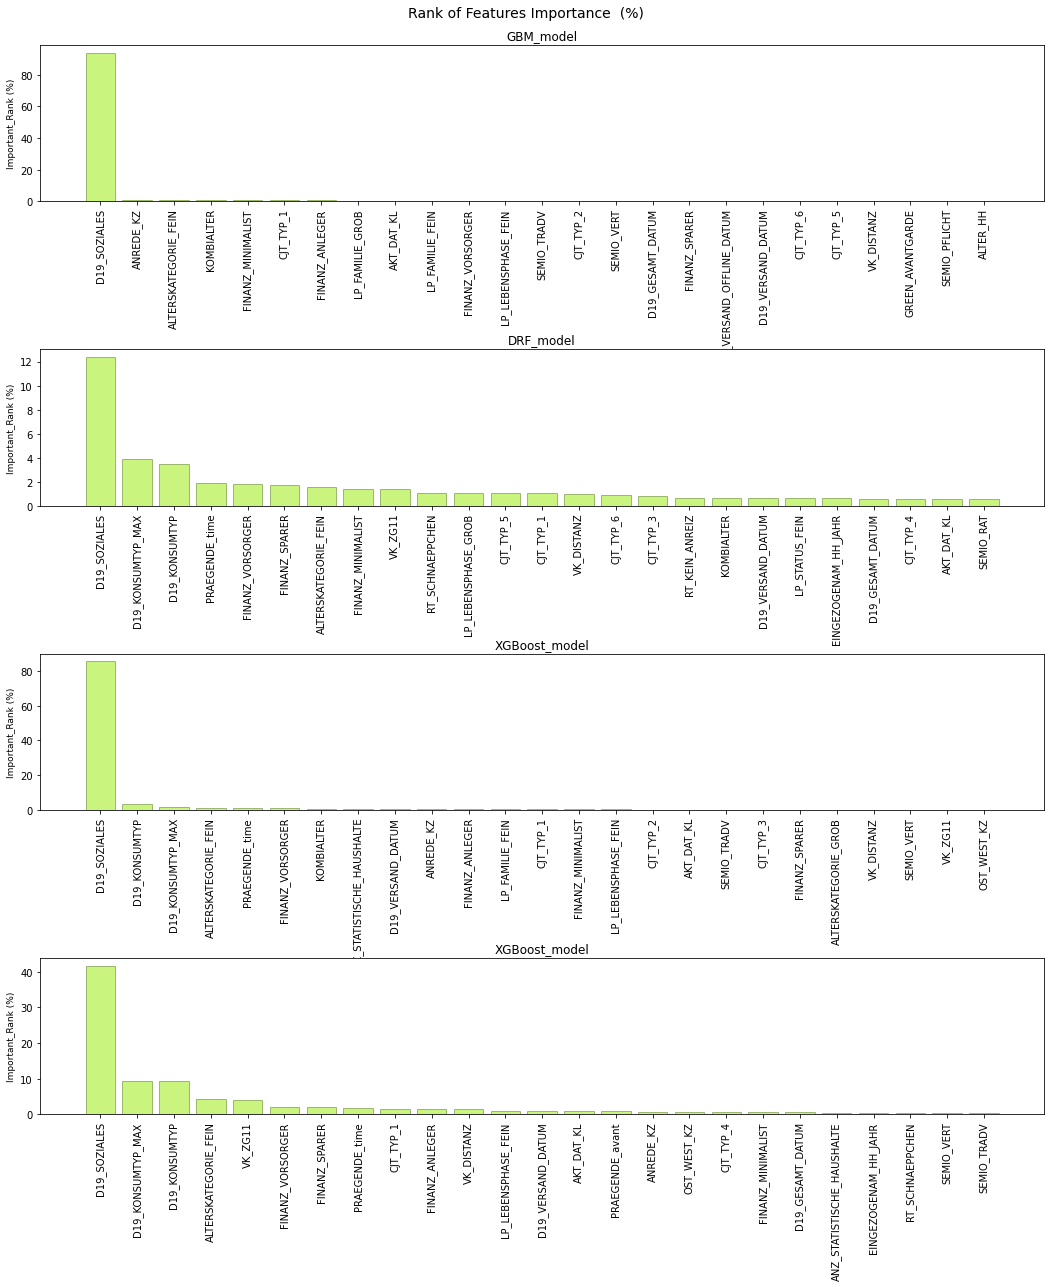

In [59]:
# Plot of Features Importance

ecolor='#138FAD'
bcolor='#95EC00'
becolor='#56781E'
plt.tight_layout 
            
# Figure size-title for Plot 
plt.subplots(figsize=(18,18))
plt.suptitle("Rank of Features Importance  (%)",fontsize = 14)  
i=411
plt.subplots_adjust(hspace=0.95, top=0.95)
for model in ensemble.base_models:
    plt.subplot(i)
    i+=1
    variable = h2o.get_model(model).varimp(use_pandas=True)[['variable', 'percentage']]
    y = np.arange(len(variable['percentage'].head(25)))
    bars = variable['variable']
    height = variable['percentage'].head(25)
    plt.bar(y, height*100, edgecolor=becolor, color=bcolor, alpha=0.5 )
    labels = bars
    plt.title(model.split('_p')[0])
    plt.xticks(y, labels, rotation=90)
    plt.ylabel('Important_Rank (%)', size=9)
    plt.show;

---
<a id="4"> </a>
# 4. Conclusion
Using 4 different models, we tried to identify the important ones in 366 features. After examining the scores of the columns I obtained from each model, I found **57 important** features. In the next stages, these **57 features will be used.**